# ECE 657 ASSIGNMENT 2: Problem 3
## RBFN

Jubilee Imhanzenobe: 20809735  
Olohireme Ajayi: 20869827  
Harnoor Singh: 20870613

In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from IPython.display import display

#### Defining the RBFN class

In [2]:
class RBFN(object):
    """ 
    Class of a RBF Neural network with 1 input layer, 1 hidden layer and 1 output layer
    """
    def __init__(self, input_size = 2, hidden_size = 2, output_size = 1, 
                 activation = "sigmoid", epochs = 1000, alpha = 0.001,
                 centroids = None, sigma = 0.5):
        """
        input_size = no of input features
        hidden_size = no of neurons in hidden layer
        output_size = no of classes for classification problem
        alpha = learning rate
        """
        
        self.centroids = centroids
        self.centroids_set = True
        
        if type(centroids) != np.ndarray:
            self.hiddenSize = hidden_size
            self.centroids_set = False
        else:
            self.hiddenSize = centroids.shape[0]
            self.centroids = centroids
            
        # setting the number on neurons in each layer
        self.inputSize = input_size
        self.outputSize = output_size
        self.epochs = epochs # no of training epochs
        self.sigma = sigma # width of rbf kernel
        self.alpha = alpha # learning rate
        
        # setting the default activation function
        self.activation = self.sigmoid
        self.activation_gradient = self.sigmoid_gradient
        
        # setting the activation function            
        if activation == 'tanh':
            self.activation = self.tanh
            self.activation_gradient = self.tanh_gradient
      
        # Randomly initializing the weights (-1 to 1)    
    
        # weight matrix from hidden to output layer
        np.random.seed(0)
        self.W2 = 2 * np.random.random((self.hiddenSize, self.outputSize)) - 1 


    def forward(self, X):
        #forward propagation through the network
        self.z3 = np.dot(X, self.W2) # dot product of hidden layer output and hidden - output weights
        o = self.activation(self.z3) # activation function to get predicted output
        return o 
      
        
    def backward(self, X, y, o):
        # backward propgation through the network
        self.o_error = y - o # error in output
        self.o_delta = self.o_error * self.activation_gradient(o) # applying activation derivative to error
        
        # update only weights between hidden layer and output        
        self.W2 += self.alpha * (X.T.dot(self.o_delta)) # updating (hidden - output) weights
        
       
    def apply_rbf(self, X):
        new_X = []
        for centroid in self.centroids:
            new_X.append(self.rbf(X, centroid, self.sigma))
            
        new_X = np.array(np.mat(new_X).T)
        return new_X
            
    
    def fit(self, X, y):
        y = np.where(y < 0, 0, y)
        if self.centroids_set == False:
            self.centroids = X[:self.hiddenSize]
         
        X_rbf = self.apply_rbf(X)
        print("Training ", end="")
        for i in range(self.epochs): # trains the NN 'epochs' times
            if i % 10 == 0:
                print(".", end="")
            o = self.forward(X_rbf)
            self.backward(X_rbf, y, o)
        print()
        
        self.model_loss = self.calc_model_loss(X, y)
    
            
    def sigmoid(self, z):
        # sigmoid function
        return 1 / ( 1 + np.exp(-z))
    
    def rbf(self, x, c, s):
        return (np.exp(-1 / (2 * s**2) * np.sum((x-c)**2, axis=1))) / ((2 * np.pi * s**2) ** 0.5)
    
        
    def sigmoid_gradient(self, z):
        #derivative of sigmoid
        return z * (1 - z)
    
    
    def tanh(self, x):
        # tanh function
        return np.tanh(x)
    
    
    def tanh_gradient(self, x):
        # derivative of tanh function
        return 1.0 - x**2
    
            
    def get_model(self):
        # returns the learned weights of the model
        return [self.W1, self.W2]
     
    
    def predict_proba(self, x_new): 
        # returns the probability of input belonging to the different classes
        
        X_rbf = self.apply_rbf(x_new)        
        y_pred_proba = self.forward(X_rbf)
        
        # for multiclass outputs, sum of classes probability must be 1
        if self.outputSize != 1:
            scale = y_pred_proba.sum(axis = 1).reshape(-1,1)
            y_pred_proba = y_pred_proba / scale
        
        return y_pred_proba
    
    
    def predict(self, x_new): 
        # returns the model's class prediction of given input
        y_pred = self.predict_proba(x_new)
        
        # for binary classification set threshold = 0.5
        if self.outputSize == 1:
            y_pred = (y_pred >= 0.5).astype(int)
            y_pred = np.where(y_pred == 0, -1, y_pred)
         
        # for multiclass classification, assign to class with highest probability
        else:
            y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
            
        return y_pred
    
    
    def calc_model_loss(self, X, y):
        X_rbf = self.apply_rbf(X) 
        # mean sum squared loss
        return np.mean(np.square(y - self.forward(X_rbf)))
    
    
    def save_model(self, filename):
        # saves model weights in specified filename
        filename = filename + ".npy"
        model = {"sigma": self.sigma, "centroids":self.centroids, "weights": self.W2}
        np.save(filename, model, allow_pickle=True)
        
    
    def load_model(self, model):
        # load weights into neural network
        self.W2 = model["weights"]
        self.sigma = model["sigma"]
        self.centroids = model["centroids"]
        


#### Defining function for calculating accuracy

In [3]:
def accuracy(y_true, y_pred):
    """ Function for calculating the accuracy """
    if not (len(y_true) == len(y_pred)):
        print('Size of predicted and true labels not equal.')
        return 0.0

    corr = 0
    for i in range(0,len(y_true)):
        corr += 1 if (y_true[i] == y_pred[i]).all() else 0

    return corr/len(y_true)


#### Function for running the tests

In [4]:
def run_test(X_train, y_train, X_test, y_test, centroids, sigmas):
    """ function for running experiment using constant widths for all RBF
    and varying the widths to see the effects of changing widths """
    
    train_accs = []
    test_accs = []
    model_losses = []
    models = []
    for sigma in sigmas:       
    
        # Initializing the Neural network
        
        rbfn = RBFN(input_size = X_train.shape[1], 
                    output_size = y_train.shape[1], 
                    centroids = centroids,
                    epochs = 500,
                    sigma = sigma)
        
        # Fitting the network to the train set
        rbfn.fit(X_train, y_train)
        
        # Checking the performance of the model on training set and test set
        y_pred_train = rbfn.predict(X_train)
        y_pred = rbfn.predict(X_test)
        
        train_acc = accuracy(y_train,y_pred_train) * 100
        test_acc = accuracy(y_test,y_pred) * 100
        model_loss = rbfn.model_loss
        
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        model_losses.append(model_loss)
        models.append(rbfn)
        
        print("Sigma (width): ", sigma)
        print("Training Accuracy: ", train_acc)
        print("Test Accuracy: ", test_acc)
        print("Model loss: ", model_loss)
        print()
        
    return train_accs, test_accs, model_losses, models

#### Helper Functions

In [5]:
def accuracy_loss_plot(accuracies, model_losses, sigmas, legend_1 = ["Train", "Test"], legend_2 = ["Model Loss"]):
    """ Function for visualizing the model performance """
    x_counts = [i for i in range(len(sigmas))]
    x_ticks = [str(sigma) for sigma in sigmas]
    
    if model_losses == None:
        fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 4))
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
        
    for accuracy in accuracies:
        ax1.plot(accuracy)
        
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Sigma')
    ax1.legend(legend_1, loc='lower right')
    ax1.set_xticks(x_counts)
    ax1.set_xticklabels(x_ticks)

    if model_losses == None:
        return
    
    for model_loss in model_losses:
        ax2.plot(model_loss)
        
    ax2.set_title('Model loss (Mean Squared Error)')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('Sigma')
    ax2.legend(legend_2, loc='upper right')
    ax2.set_xticks(x_counts)
    ax2.set_xticklabels(x_ticks)

In [6]:
def class_boundary(X_set, y_set, model, title):
    """ Function for visualizing model classification boundary """
    X1, X2 = np.meshgrid(np.arange(start = -2, stop = 2, step = 0.01),
                         np.arange(start = -2, stop = 2, step = 0.01))
    plt.contourf(X1, X2, model.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.75, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set[:,0] == j, 0], X_set[y_set[:,0] == j, 1],
                    color = ListedColormap(('red', 'green'))(i), label = j)
    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend(loc="lower right")
    plt.show()

#### Creating the dataset

In [7]:
""" Creating the dataset """
x = []
for i in range(21):
    for j in range(21):
        x.append([i,j])
        
x = np.array(x)

X = -2 + 0.2 * x

y = np.where((X[:,0] ** 2 + X[:,1] ** 2 <= 1), 1, -1)

#### Visualizing the dataset

<AxesSubplot:>

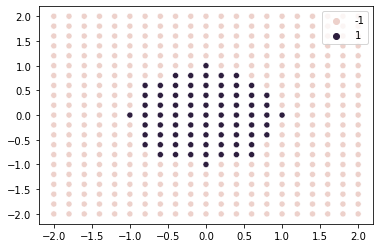

In [8]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue = y)

In [9]:
""" splitting the data into training set and test set """
# training set and test set with 80:20 ratio
y = y.reshape((-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=275)

## Experiment 1

Experiment using all input points as centroids with constant widths for all RBF
and varying the widths to see the effects of changing widths on model loss and accuracy of RBFN.

In [10]:
sigmas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 5, 10, 100]

In [11]:
%%time
centroids = X_train
train_acc_1, test_acc_1, model_losses_1, model_1 = run_test(X_train, y_train, X_test, y_test, centroids, sigmas)

Training ..................................................
Sigma (width):  0.01
Training Accuracy:  57.67045454545454
Test Accuracy:  19.101123595505616
Model loss:  0.4231336031473347

Training ..................................................
Sigma (width):  0.05
Training Accuracy:  69.88636363636364
Test Accuracy:  65.1685393258427
Model loss:  0.28772297115062073

Training ..................................................
Sigma (width):  0.1
Training Accuracy:  72.1590909090909
Test Accuracy:  71.91011235955057
Model loss:  0.2180173848703248

Training ..................................................
Sigma (width):  0.2
Training Accuracy:  91.76136363636364
Test Accuracy:  88.76404494382022
Model loss:  0.0715807124130645

Training ..................................................
Sigma (width):  0.3
Training Accuracy:  96.02272727272727
Test Accuracy:  92.13483146067416
Model loss:  0.04361041193312453

Training ..................................................
Sigma (width

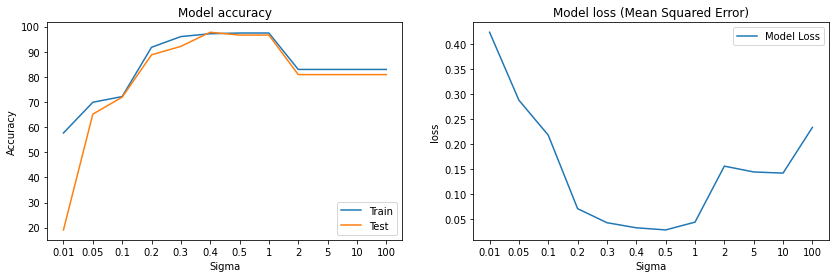

In [12]:
columns = ["Sigma", "Train Acc", "Test Acc", "Model Loss"]
results_1 = pd.DataFrame(np.array([sigmas, train_acc_1, test_acc_1, model_losses_1]).T, columns = columns)
accuracy_loss_plot([train_acc_1, test_acc_1], [model_losses_1], sigmas)

### <span style="color:blue"> Observations </span>
In this experiment, all the training datapoints were used as centroids and the RBF width was varied through 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 5, 10, 100 and the following results were gotten.

In [13]:
display(results_1)

,Sigma,Train Acc,Test Acc,Model Loss
0,0.01,57.670455,19.101124,0.423134
1,0.05,69.886364,65.168539,0.287723
2,0.10,72.159091,71.910112,0.218017
3,0.20,91.761364,88.764045,0.071581
4,0.30,96.022727,92.134831,0.043610
5,0.40,97.159091,97.752809,0.033455
6,0.50,97.443182,96.629213,0.029231
7,1.00,97.443182,96.629213,0.044700
8,2.00,82.954545,80.898876,0.156331
9,5.00,82.954545,80.898876,0.144727


From the table of results and the accuracy and loss plots it can be observed that the model perform poorly in terms of training accuracy, testing accuracy and model loss for very low values of sigma (widths) and as the width increases, the performance of the model improves until it reaches a peak and starts to drop again. The model performed best with maximum accuracy and minimum loss with sigma (width) between 0.4 and 0.5.

### <span style="color:blue"> Further investigation using classification boundary </span>

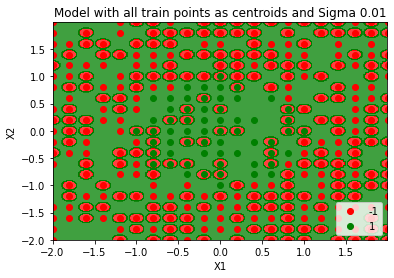

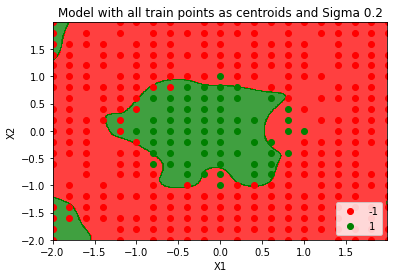

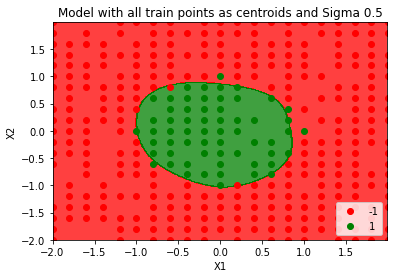

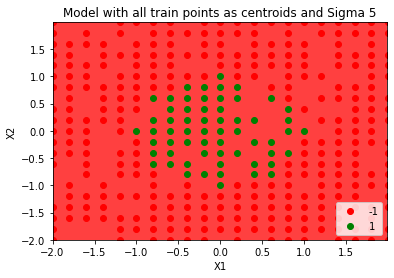

In [14]:
for i in range(len(model_1)):
    if i % 3 == 0:
        title = "Model with all train points as centroids and Sigma " + str(sigmas[i])
        class_boundary(X_train, y_train, model_1[i], title)

From the plots showing the classification boundaries, it can be seen that for very low values of sigma, the model tends to memorize the centroid locations and since the training points were used as centroid locations, it tends to memorize a particualr class of the training data thus performing poorly on the other class and not generalizing well.  

For optimal values of sigma, the model performs great and learns an appropriate ovoidal boundary at the center of the plot showing that the model has learnt an appropriate approximate function for mapping the inputs to the classes. The model also generalizes well as it performs well on new observations (test set).  

For large values of sigma, the model again performs poorly as it only classifies one class. It assumes all inputs belong to one class and is unable to classify samples belonging to the other class.

## Experiment 2a

Experiment selecting 150 random samples from the training data without replacement as centroids with constant widths for all RBF and varying the widths to see the effects of changing widths on model loss and accuracy of RBFN.

In [15]:
%%time
idx = np.random.choice(X_train.shape[0], size=150, replace=False)
centroids = X_train[idx]
train_acc_2, test_acc_2, model_losses_2, model_2  = run_test(X_train, y_train, X_test, y_test, centroids, sigmas)

Training ..................................................
Sigma (width):  0.01
Training Accuracy:  34.375
Test Accuracy:  19.101123595505616
Model loss:  0.31677466069564725

Training ..................................................
Sigma (width):  0.05
Training Accuracy:  65.05681818181817
Test Accuracy:  56.17977528089888
Model loss:  0.2614622820594803

Training ..................................................
Sigma (width):  0.1
Training Accuracy:  69.60227272727273
Test Accuracy:  60.67415730337079
Model loss:  0.22958887082276147

Training ..................................................
Sigma (width):  0.2
Training Accuracy:  85.79545454545455
Test Accuracy:  76.40449438202246
Model loss:  0.11616569908886198

Training ..................................................
Sigma (width):  0.3
Training Accuracy:  94.31818181818183
Test Accuracy:  93.25842696629213
Model loss:  0.0721640784003872

Training ..................................................
Sigma (width):  0.4


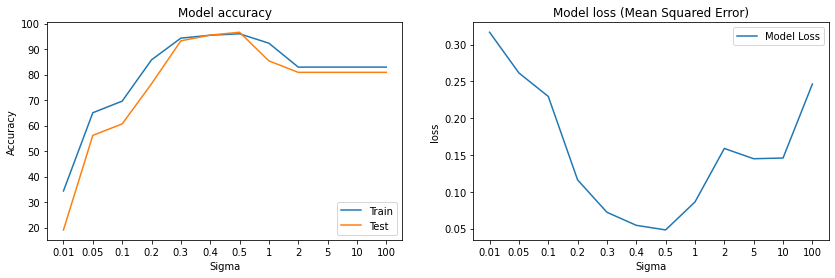

In [16]:
results_2 = pd.DataFrame(np.array([sigmas, train_acc_2, test_acc_2, model_losses_2]).T, columns = columns)
accuracy_loss_plot([train_acc_2, test_acc_2], [model_losses_2], sigmas)

### <span style="color:blue"> Observations </span>
In this experiment, all the training datapoints were used as centroids and the RBF width was varied through 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 5, 10, 100 and the following results were gotten.

In [17]:
display(results_2)

,Sigma,Train Acc,Test Acc,Model Loss
0,0.01,34.375000,19.101124,0.316775
1,0.05,65.056818,56.179775,0.261462
2,0.10,69.602273,60.674157,0.229589
3,0.20,85.795455,76.404494,0.116166
4,0.30,94.318182,93.258427,0.072164
5,0.40,95.454545,95.505618,0.054451
6,0.50,96.022727,96.629213,0.048230
7,1.00,92.329545,85.393258,0.086234
8,2.00,82.954545,80.898876,0.158888
9,5.00,82.954545,80.898876,0.144928


From the table of results and the accuracy and loss plots it can be observed that the model perform poorly in terms of training accuracy, testing accuracy and model loss for very low values of sigma (widths) and as the width increases, the performance of the model improves until it reaches a peak and starts to drop again. The model performed best with maximum accuracy and minimum loss with sigma (width) between 0.4 and 0.5.

### <span style="color:blue"> Further investigation using classification boundary </span>

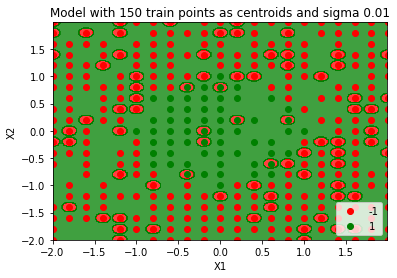

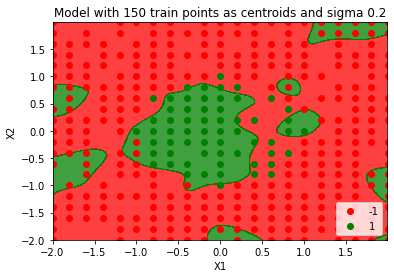

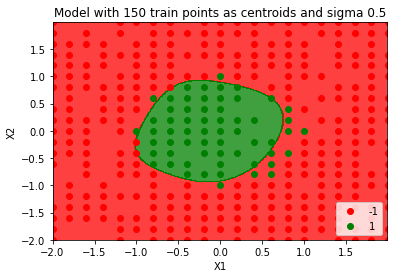

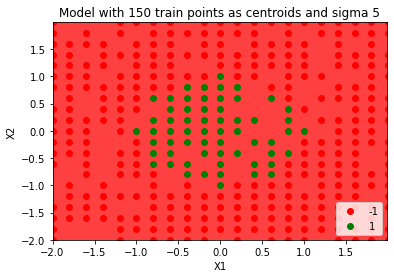

In [18]:
for i in range(len(model_2)):
    if i % 3 == 0:
        title = "Model with 150 train points as centroids and sigma " + str(sigmas[i])
        class_boundary(X_train, y_train, model_2[i], title)

From the plots showing the classification boundaries, it can be seen that for very low values of sigma, the model tends to memorize the centroid locations and since the training points were used as centroid locations, it tends to memorize a particualr class of the training data thus performing poorly on the other class and not generalizing well.  

For optimal values of sigma, the model performs great and learns an appropriate ovoidal boundary at the center of the plot showing that the model has learnt an appropriate approximate function for mapping the inputs to the classes. The model also generalizes well as it performs well on new observations (test set).  

For large values of sigma, the model again performs poorly as it only classifies one class. It assumes all inputs belong to one class and is unable to classify samples belonging to the other class.

## Experiment 2b

Experiment using KMeans clustering to find 150 centroid points with constant widths for all RBF and varying the widths to see the effects of changing widths on model loss and accuracy of RBFN.

In [19]:
%%time
# using KNN to find the centroids
kmeans = KMeans(n_clusters = 150)
kmeans.fit(X_train)

centroids = kmeans.cluster_centers_
train_acc_3, test_acc_3, model_losses_3, model_3  = run_test(X_train, y_train, X_test, y_test, centroids, sigmas)

Training ..................................................
Sigma (width):  0.01
Training Accuracy:  20.454545454545457
Test Accuracy:  19.101123595505616
Model loss:  0.26137137879208877

Training ..................................................
Sigma (width):  0.05
Training Accuracy:  49.14772727272727
Test Accuracy:  60.67415730337079
Model loss:  0.260569272113858

Training ..................................................
Sigma (width):  0.1
Training Accuracy:  67.61363636363636
Test Accuracy:  69.66292134831461
Model loss:  0.22065808127896885

Training ..................................................
Sigma (width):  0.2
Training Accuracy:  86.64772727272727
Test Accuracy:  85.39325842696628
Model loss:  0.10651291594067548

Training ..................................................
Sigma (width):  0.3
Training Accuracy:  96.30681818181817
Test Accuracy:  96.62921348314607
Model loss:  0.062126582465003306

Training ..................................................
Sigma (

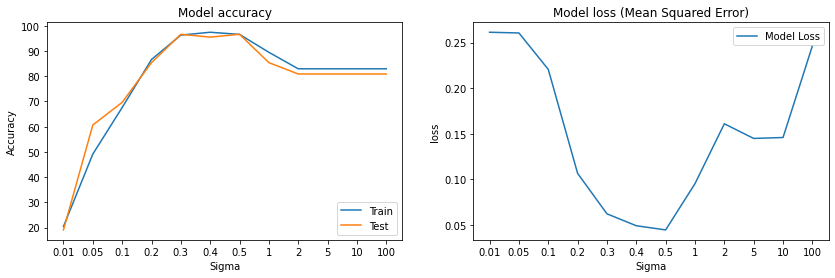

In [20]:
results_3 = pd.DataFrame(np.array([sigmas, train_acc_3, test_acc_3, model_losses_3]).T, columns = columns)
accuracy_loss_plot([train_acc_3, test_acc_3], [model_losses_3], sigmas)

### <span style="color:blue"> Observations </span>
In this experiment, all the training datapoints were used as centroids and the RBF width was varied through 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 5, 10, 100 and the following results were gotten.

In [21]:
display(results_3)

,Sigma,Train Acc,Test Acc,Model Loss
0,0.01,20.454545,19.101124,0.261371
1,0.05,49.147727,60.674157,0.260569
2,0.10,67.613636,69.662921,0.220658
3,0.20,86.647727,85.393258,0.106513
4,0.30,96.306818,96.629213,0.062127
5,0.40,97.443182,95.505618,0.049052
6,0.50,96.590909,96.629213,0.044474
7,1.00,89.488636,85.393258,0.095258
8,2.00,82.954545,80.898876,0.160949
9,5.00,82.954545,80.898876,0.144848


From the table of results and the accuracy and loss plots it can be observed that the model perform poorly in terms of training accuracy, testing accuracy and model loss for very low values of sigma (widths) and as the width increases, the performance of the model improves until it reaches a peak and starts to drop again. The model performed best with maximum accuracy and minimum loss with sigma (width) between 0.4 and 0.5.

### <span style="color:blue"> Further investigation using classification boundary </span>

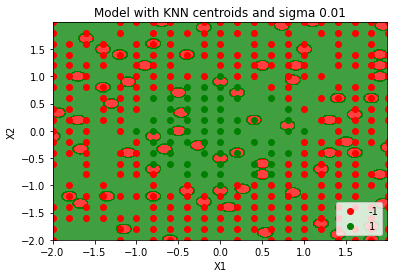

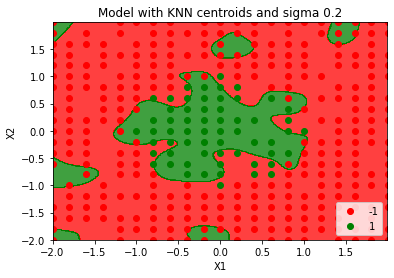

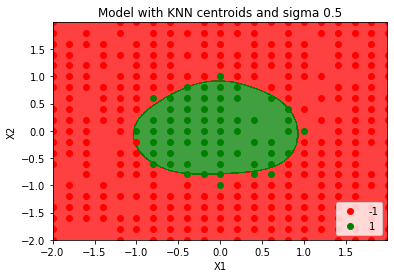

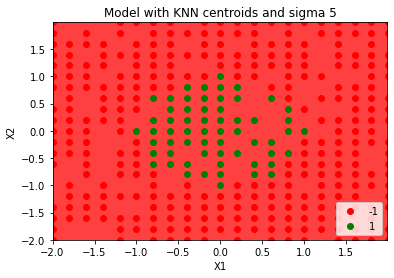

In [22]:
for i in range(len(model_3)):
    if i % 3 == 0:
        title = "Model with KNN centroids and sigma " + str(sigmas[i])
        class_boundary(X_train, y_train, model_3[i], title)

From the plots showing the classification boundaries, it can be seen that for very low values of sigma, the model tends to memorize the centroid locations and since the training points were used as centroid locations, it tends to memorize a particualr class of the training data thus performing poorly on the other class and not generalizing well.  

For optimal values of sigma, the model performs great and learns an appropriate ovoidal boundary at the center of the plot showing that the model has learnt an appropriate approximate function for mapping the inputs to the classes. The model also generalizes well as it performs well on new observations (test set).  

For large values of sigma, the model again performs poorly as it only classifies one class. It assumes all inputs belong to one class and is unable to classify samples belonging to the other class.

## Comparing the different centroid initialization methods

##### Training accuracy and model loss

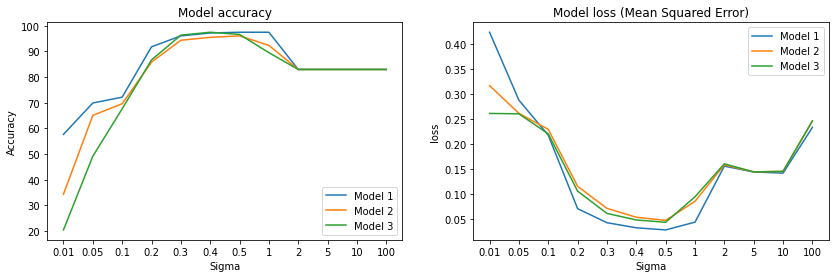

In [23]:
accuracy_loss_plot([train_acc_1, train_acc_2, train_acc_3], 
                   [model_losses_1, model_losses_2, model_losses_3], 
                   sigmas,
                   legend_1 = ["Model 1", "Model 2", "Model 3"], 
                   legend_2 = ["Model 1", "Model 2", "Model 3"])

##### Test accuracy

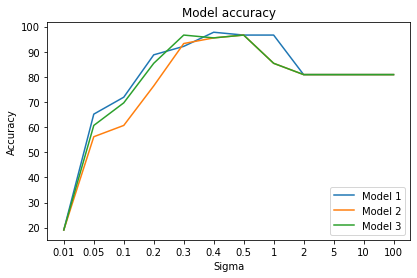

In [24]:
accuracy_loss_plot([test_acc_1, test_acc_2, test_acc_3], 
                   None, 
                   sigmas,
                   legend_1 = ["Model 1", "Model 2", "Model 3"])

### <span style="color:blue"> Observations </span>

<span style="color:green"> Model 1: Model with all training datapoints as centroid locations</span>  
<span style="color:green"> Model 2: Model with 150 random training datapoints as centroid locations</span>  
<span style="color:green"> Model 3: Model with 150 centroids gotten using KMeans clustering</span> 


Overall, The models with the 3 different RBF centroid initializations performed comparably the same with the optimal sigma value (0.4 - 0.5). They all had training accuracies > 96, test accuracies > 96 and model loss <= 0.05. Model 1 was observed to show the minimum model loss among the three models for this sigma range.

For very small RBF widths, the Model 1 had the highest training accuracy but had the highest model loss and generalization error with is indicative of the fact the the model tends to memorize a class rather than learning an approximate function to distinguish the two classes.  

For very large RBF widths (sigma > 2), all the models had similar performance. Their performance was lower than that of the optimal sigma value and from the classification boundary plots previously shown, it is indicative of the model classifyin all points as the -1 class.